In [1]:
import numpy as np
import pandas as pd
import sklearn, sklearn.preprocessing, sklearn.model_selection, sklearn.linear_model, sklearn.metrics, sklearn.feature_selection, sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns

# Numbers display set-up
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# 1) Data Preparation

We are going to use following dataset to train a model for predicting a yearly salary (total compensation) when we are hiring a new employee. This model can help to HR department. Credit to Worksday's tutorial on ML Prague.

In [2]:
df = pd.read_csv('hr-data.csv')
df.shape

(5000, 24)

In [3]:
df.head(3)

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
0,1.545,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,Asian,Female,Generation X (1965-1980),False,False,Referral,True,True,Executive,M9,Executive Management - Chief Executive Officer,26.934,San Francisco,Chief Executive Officer,AMER,Executive Management,15+ Years,772400,57.000
1,1.021,At Compa-Ratio,AMER - United States of America,United States of America,3 - Meets Expectations,White,Male,Generation Z (1997 and onwards),False,True,Referral,False,False,Development,P2,IT - Product Development - P2 Business Analytics,1.844,New York,Individual Contributor,AMER,IT - Product Development,01-02 Years,68900,25.000
2,0.981,At Compa-Ratio,Global Support - Asia/Pac,South Korea,5 - Outstanding Performance,Asian,Male,Generation Y/Millenials (1981-1996),True,False,Recruiter,False,False,Development,P3,IT - Product Development - P3 Data Scientist,2.192,Seoul,Individual Contributor,APAC,IT - Product Development,02-05 Years,53200,33.000


In [4]:
df.describe(include="all")

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
count,5000.000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000,5000,5000,5000,5000,5000,5000.000,5000.000
unique,NaN,3,5,6,5,5,2,4,2,2,6,2,2,5,13,90,NaN,19,6,3,11,6,NaN,NaN
top,NaN,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,White,Female,Generation Y/Millenials (1981-1996),False,False,Referral,False,False,Development,P4,Board Management - Senior Board Associate,NaN,San Francisco,Individual Contributor,AMER,IT - Product Development,05-10 Years,NaN,NaN
freq,NaN,3284,1275,1275,1013,2282,2500,3364,3992,4227,1531,4674,4409,1476,1334,242,NaN,876,3913,2515,1309,1359,NaN,NaN
mean,1.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.997,NaN,NaN,NaN,NaN,NaN,131567.360,36.859
std,0.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.745,NaN,NaN,NaN,NaN,NaN,107949.422,10.741
min,0.639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,24600.000,21.000
25%,0.990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.595,NaN,NaN,NaN,NaN,NaN,67500.000,29.000
50%,1.173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.699,NaN,NaN,NaN,NaN,NaN,104300.000,34.000
75%,1.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.648,NaN,NaN,NaN,NaN,NaN,152700.000,40.000


In [5]:
df.tenure_category.value_counts().index

Index(['05-10 Years', '02-05 Years', '10-15 Years', '15+ Years', '00-01 Years',
       '01-02 Years'],
      dtype='object', name='tenure_category')

In [6]:
df.replace(np.nan, "nan", regex=True, inplace=True)
categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns

Index(['compa_ratio_range', 'cost_center', 'country', 'current_rating',
       'ethnicity', 'gender', 'generation', 'hiring_source',
       'job_family_group', 'job_level', 'job_profile', 'location',
       'management_level', 'region', 'single_job_family', 'tenure_category'],
      dtype='object')

In [7]:
ordinal_columns_category_order_dict = {
    'compa_ratio_range': ['Below Compa-Ratio', 'At Compa-Ratio', 'Above Compa-Ratio'],
    'current_rating': ['1 - Unsatisfactory', '2 - Needs Improvement', '3 - Meets Expectations', '4 - Exceeds Expectations', '5 - Outstanding Performance'],
    'tenure_category': ['00-01 Years', '01-02 Years', '02-05 Years', '05-10 Years', '10-15 Years', '15+ Years']
}

In [8]:
df_encoded = df.select_dtypes(exclude=["object"]).copy()
for col in ['high_performer', 'high_potential', 'is_leader', 'is_manager']:
    df_encoded[col] = df_encoded[col].astype(int)
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age
0,1.545,0,0,1,1,26.934,772400,57.000
1,1.021,0,1,0,0,1.844,68900,25.000
2,0.981,1,0,0,0,2.192,53200,33.000
3,1.342,0,1,0,0,18.518,204600,45.000
4,1.290,0,0,0,0,1.416,70000,32.000


In [9]:
ordinal_encoder = sklearn.preprocessing.OrdinalEncoder(categories=[ordinal_columns_category_order_dict[column] for column in ordinal_columns_category_order_dict.keys()])
df_encoded = df_encoded.join(pd.DataFrame(ordinal_encoder.fit_transform(df[ordinal_columns_category_order_dict.keys()]), index=df.index, columns=ordinal_columns_category_order_dict.keys()))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category
0,1.545,0,0,1,1,26.934,772400,57.000,2.000,3.000,5.000
1,1.021,0,1,0,0,1.844,68900,25.000,1.000,2.000,1.000
2,0.981,1,0,0,0,2.192,53200,33.000,1.000,4.000,2.000
3,1.342,0,1,0,0,18.518,204600,45.000,2.000,1.000,5.000
4,1.290,0,0,0,0,1.416,70000,32.000,2.000,2.000,1.000


In [10]:
nominal_columns = [column for column in categorical_columns if column not in ordinal_columns_category_order_dict.keys()]
df_encoded = df_encoded.join(pd.get_dummies(df[nominal_columns], prefix_sep="="))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Devel

In [11]:
df_encoded.shape

(5000, 186)

# 2) Linear Regression

There are a few assumptions associated with a linear regression model:

* Linearity: The relationship between X and Y is linear.
* Homoscedasticity: The variance of residual is the same for any value of X.
* No multicollinearity: There is no high correlations among two or more independent variables.
* Independence: Observations are independent of each other.
* Normality: For any fixed value of X, Y is normally distributed.

In [12]:
X_data = df_encoded.drop('total_compensation', axis=1)
y_data = df_encoded['total_compensation']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_data, y_data, test_size=0.20, random_state=12
)
column_names = X_train.columns

In [13]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 885066188.1491685
Root Mean Squared Error: 2.1618124564518696e+16
R-squared: -4.394497598504088e+22


In [15]:
residuals.describe()

count                  1000.000
mean       -683625123651441.125
std       21618124564519008.000
min     -683625123651147392.000
25%                   -6414.334
50%                    -952.334
75%                    6437.666
max                   75793.666
Name: total_compensation, dtype: float64

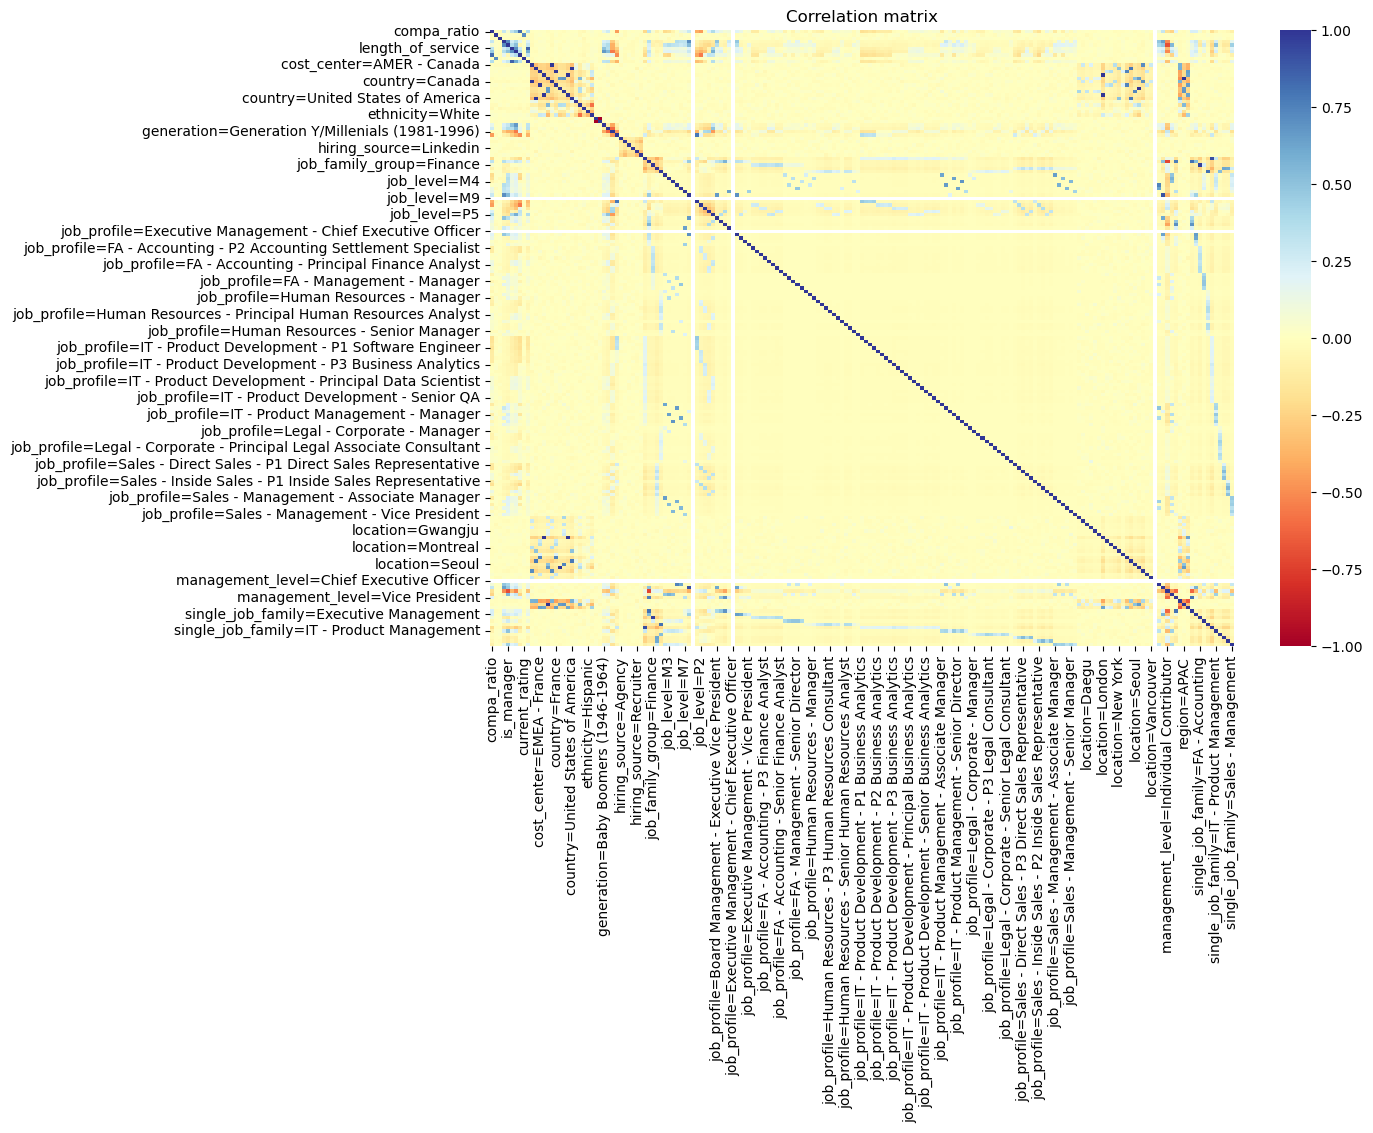

In [16]:
# We broke multicollinearity assumption by using all features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()
# NOTE: White line represents columns which contain only zeros

# 3) Orthogonal Matching Pursuit

In [17]:
n_coefs = 11
model = sklearn.linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.12508973808636578
Root Mean Squared Error: 25115.239688207013
R-squared: 0.9406872778959967


What are the residuals?

In [18]:
residuals.describe()

count      1000.000
mean        -71.508
std       25127.705
min     -136974.590
25%       -9392.462
50%       -2249.060
75%        6910.988
max      465699.425
Name: total_compensation, dtype: float64

How does the target attribute looks like?

<Axes: >

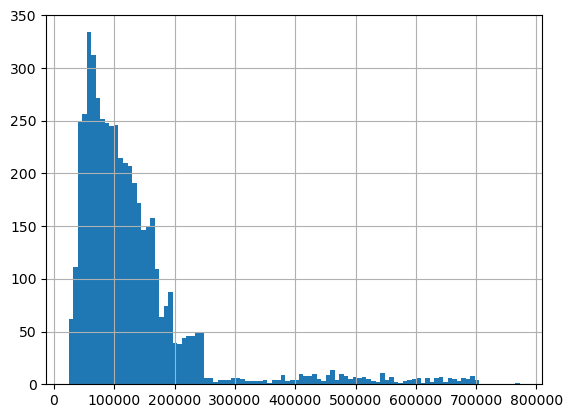

In [19]:
df['total_compensation'].hist(bins=100)

What is the model doing? There is a linear model inside :-).

In [20]:
y_pred = X_test_scaled @ model.coef_ + model.intercept_
y_pred[:5]

array([40012.98749039, 72509.05456051, 26720.48469275, 74277.72802948,
       43852.45827751])

### Use coefficients estimated by OMP to visualize their impact using (e.g.: seaborn, matplotlib). Think about the interpretation of the visualization, especially "age", "job_level -> M8" and "generation -> Baby Boomers (1946 - 1964)".

In [21]:
n_coefs = 11
model = sklearn.linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)

OrthogonalMatchingPursuit(n_nonzero_coefs=11)

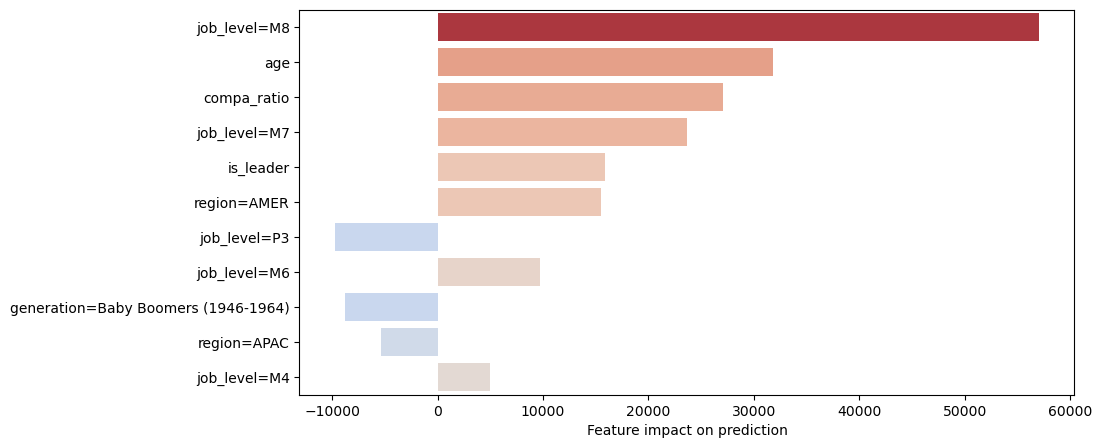

In [22]:
# Visualise the features that have been selected and their respective scores
feature_scores = pd.Series(model.coef_, index=X_data.columns).sort_values(ascending=False, key=lambda x: abs(x))
selected_features = feature_scores[:n_coefs]

f, ax = plt.subplots(figsize=(10, 5))
shades = 31
palette = sns.color_palette('coolwarm', shades)
minmax = np.max([-np.min(selected_features), np.max(selected_features)])
bins = np.linspace(-minmax, minmax, num=shades)
palette_indices = np.digitize(selected_features, bins) - 1
colors = [palette[idx] for idx in palette_indices]

ax = sns.barplot(x=selected_features, y=selected_features.index, palette=colors, dodge=False)
ax.set_yticklabels(selected_features.index)
ax.set_xlabel('Feature impact on prediction')
plt.show()

#### What you can tell about these features?

#### Lets see what a one year change in age can do

In [23]:
X_test.iloc[0:1]

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [24]:
pd.DataFrame(X_test_scaled[0:1, :], columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [25]:
X_new_entry = X_test.iloc[0:1].copy()
X_new_entry['age'] += 1

In [26]:
pd.DataFrame(scaler.transform(X_new_entry), columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [27]:
y_test[0:1]

4506    44500
Name: total_compensation, dtype: int64

In [28]:
model.predict(X_test_scaled[0:1, :])

array([40012.98749039])

In [29]:
model.predict(scaler.transform(X_new_entry))

array([42974.87222143])

## Run again Linear Regression only for selected features. Did the feature selection resolves original problem?

In [30]:
selected_features.index

Index(['job_level=M8', 'age', 'compa_ratio', 'job_level=M7', 'is_leader',
       'region=AMER', 'job_level=P3', 'job_level=M6',
       'generation=Baby Boomers (1946-1964)', 'region=APAC', 'job_level=M4'],
      dtype='object')

In [31]:
model = sklearn.linear_model.LinearRegression()
model.fit(pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features.index], y_train)
y_pred = model.predict(pd.DataFrame(X_test_scaled, columns=X_test.columns)[selected_features.index])
residuals = y_test - y_pred

# Evaluate the model
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.1250897380863656
Root Mean Squared Error: 25115.23968820696
R-squared: 0.940687277895997


# 3) Random Forest and Boruta feature selection

* https://medium.com/geekculture/boruta-feature-selection-explained-in-python-7ae8bf4aa1e7

In [32]:
# Install package not available in Colab by default
# !pip install boruta

### Specify a base RF model and use it to run Boruta feature selection

In [34]:
from boruta import BorutaPy

In [35]:
# Base RF model specification
rf = sklearn.ensemble.RandomForestRegressor(max_depth=20, random_state=123)

In [36]:
# Boruta feature search
feat_selector = BorutaPy(
    verbose=2,
    estimator=rf,
    n_estimators=20,
    max_iter=25,
    random_state=123
)

feat_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	9 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	10 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	11 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	12 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	13 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	14 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	15 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	16 / 25
Confirmed: 	22
Tentative: 	3
Rejecte

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=20,
                                         random_state=RandomState(MT19937) at 0x18395500940),
         max_iter=25, n_estimators=20,
         random_state=RandomState(MT19937) at 0x18395500940, verbose=2)

In [37]:
# Get the list of selected features
boruta_selected = []

for i in range(len(feat_selector.support_)):
    if (feat_selector.support_[i] or feat_selector.support_weak_[i]):
        boruta_selected.append(X_train.columns[i])
        print(X_train.columns[i])

compa_ratio
is_leader
is_manager
age
cost_center=Global Support - Asia/Pac
job_level=M4
job_level=M5
job_level=M6
job_level=M7
job_level=M8
job_level=P1
job_level=P2
job_level=P3
job_level=P4
job_level=P5
job_profile=Executive Management - Executive Vice President
job_profile=Executive Management - Vice President
management_level=Director
management_level=Executive Vice President
management_level=Vice President
region=AMER
region=APAC
region=EMEA


In [38]:
print('Number of selected features: ', len(boruta_selected))

Number of selected features:  23


### Run RF model with features selected by Boruta

In [39]:
# Get subsets of explanatory variables only with features that were selected
X_filtered_train = X_train[boruta_selected]
X_filtered_test = X_test[boruta_selected]

In [40]:
# Model specification 
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_filtered_train, y_train)

# Get predictions
y_pred_BR_sel = rf.predict(X_filtered_test)

In [41]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_BR_sel, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_BR_sel)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_BR_sel)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.004961502884308441
Root Mean Squared Error: 7398.123120025602
R-squared: 0.9948534486445018


### Run RF model with all features

In [42]:
# Model specification 
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_train, y_train)

# Get predictions
y_pred_rf = rf.predict(X_test)

In [43]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.006767382522046515
Root Mean Squared Error: 7971.37300524934
R-squared: 0.994024978604095


# Tasks
## Task 1: Use a *feature_importance* param in Random Forest (RF) for feature selection
1. Fit RF model without feature selection
2. Select the most important features using variable importance scores
    - Visualize the value of *feature_importance* for attributes
3. Fit the RF model again, now with selected features only


In [44]:
rf.feature_importances_

array([4.00413275e-02, 1.47763891e-05, 1.11659795e-05, 6.01338744e-01,
       4.15193098e-03, 1.75461120e-04, 1.60359688e-01, 7.24767888e-05,
       9.50757725e-05, 4.58076690e-05, 8.18900682e-06, 4.77787273e-05,
       1.48179325e-05, 1.46201232e-06, 9.05155704e-04, 9.96586184e-05,
       1.20916321e-05, 4.49470128e-05, 3.78840397e-05, 6.60289136e-06,
       5.87832275e-05, 1.47950729e-06, 5.72946643e-05, 1.07988906e-06,
       3.27796297e-06, 1.00186691e-04, 2.84092089e-05, 2.38597495e-05,
       4.59741552e-05, 2.13040298e-04, 9.01465848e-06, 2.40379778e-09,
       6.77547701e-06, 1.20822431e-04, 1.14170555e-05, 3.43625952e-06,
       3.66044490e-05, 1.24282571e-05, 5.31979138e-06, 2.42109773e-06,
       4.32013012e-06, 8.24202316e-06, 4.25904595e-06, 6.64073337e-05,
       7.61643592e-05, 4.32134918e-04, 1.25683387e-03, 1.66326948e-03,
       8.16509702e-03, 3.16221702e-02, 0.00000000e+00, 1.47557854e-03,
       3.79833090e-04, 1.17481152e-03, 3.82495918e-03, 3.28338594e-03,
      

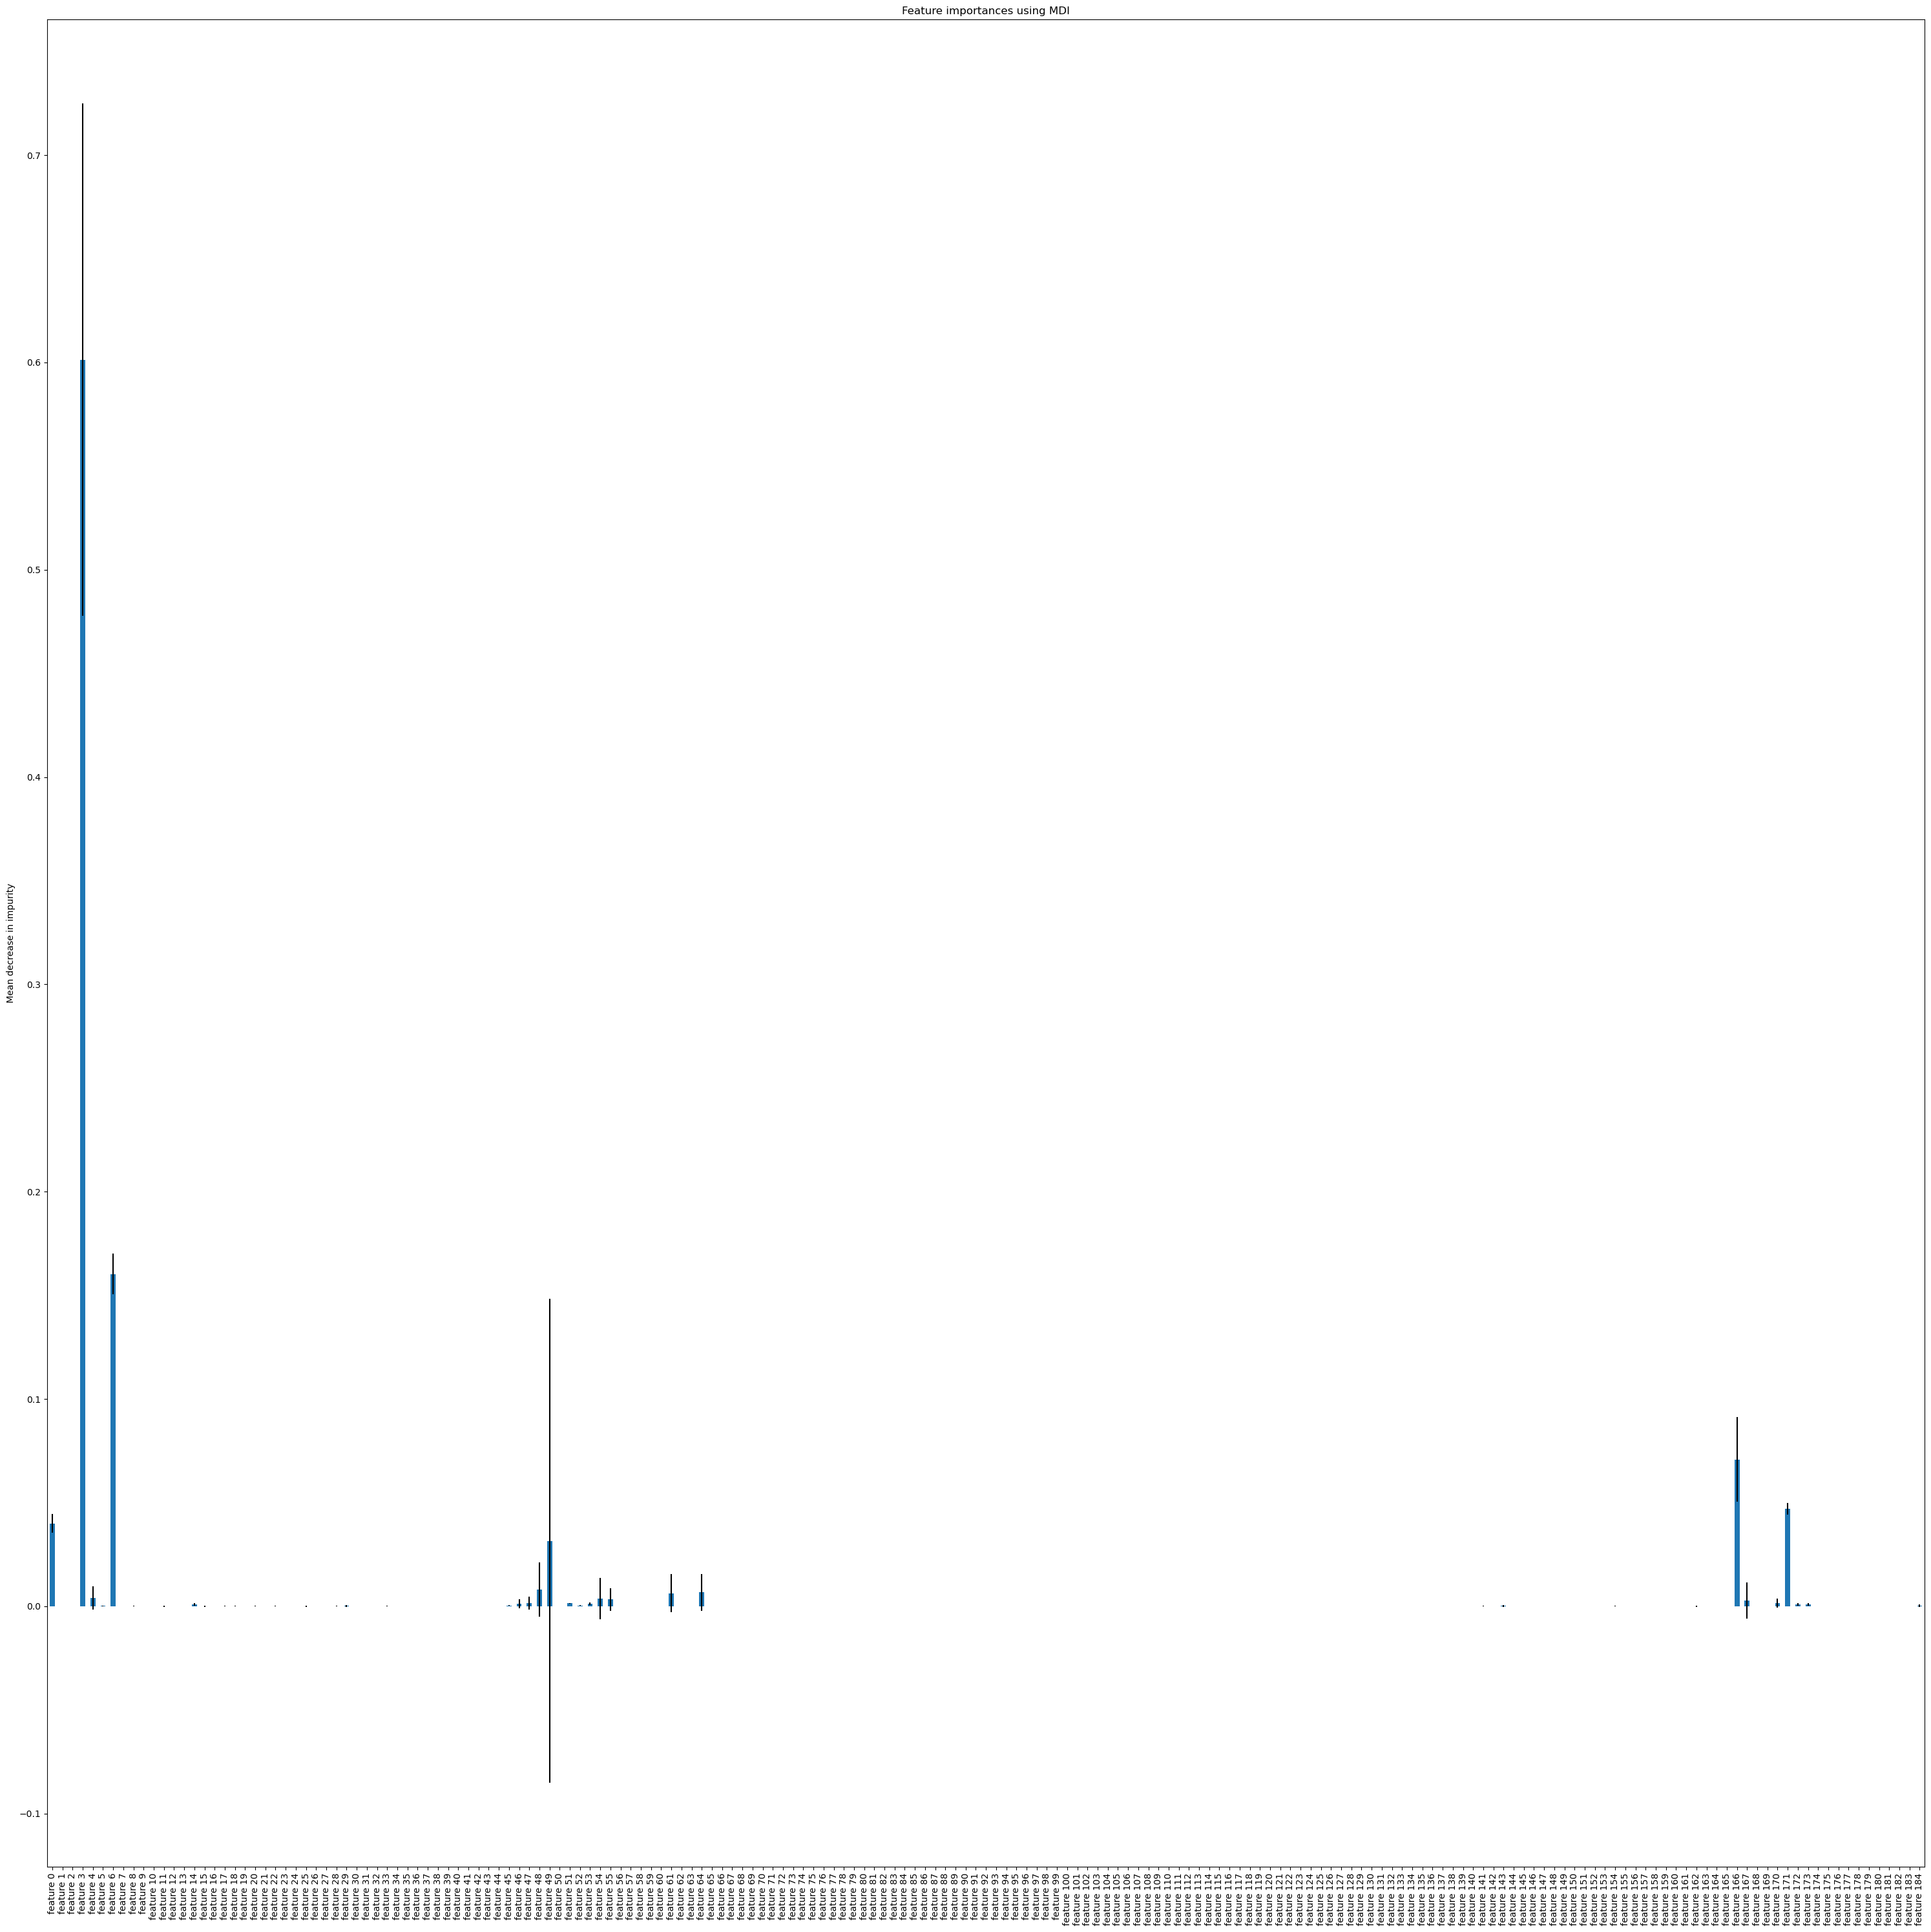

In [ ]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
features = rf.feature_importances_
forest_importances = pd.Series(features, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots(figsize=(30,30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [54]:
selectedFeatures = [(i,x) for i, x in enumerate(features) if x > 0.01]

In [55]:
selectedFeatures

[(0, 0.04004132749001474),
 (3, 0.6013387438582184),
 (6, 0.1603596883169118),
 (49, 0.031622170164610684),
 (166, 0.07085092552338461),
 (171, 0.04709913805857089)]

In [57]:
featureNames = [X_train.columns[i] for i,x in selectedFeatures]
featureNames

['compa_ratio',
 'is_leader',
 'age',
 'job_level=M8',
 'management_level=Director',
 'region=AMER']

In [58]:
X_filtered_train = X_train[featureNames]
X_filtered_test = X_test[featureNames]

In [61]:
# Model specification 
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_filtered_train, y_train)

# Get predictions
y_pred_rf = rf.predict(X_filtered_test)

In [62]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.05316169943503391
Root Mean Squared Error: 17902.453968408092
R-squared: 0.9698631169311139


## Task 2: Summarize the insights gained in this analysis
Try some other regression model. You can choose different algorithm or different parameters.

Create a conlusion for this analysis. You can write about something from following list:
- Report the prediction scores achived by various models.
- What features were found important when solving this regression task?

Imagine, you are presenting these results to HR deparment team. Did you get any relevant information for that presentation in this analysis?

In [72]:
# Model specification 
import sklearn.svm


rf = sklearn.svm.SVR()

# Fit the model
rf.fit(X_train_scaled, y_train)

# Get predictions
y_pred_rf = rf.predict(X_test_scaled)

In [73]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.5032967137611081
Root Mean Squared Error: 106556.19317557996
R-squared: -0.06765415517633988


In [75]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test_scaled, y_test)
feature_names = X_train_scaled.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

KeyboardInterrupt: 

In [70]:
# Model specification 
import sklearn.svm


rf = sklearn.svm.SVR()

# Fit the model
rf.fit(X_filtered_train, y_train)

# Get predictions
y_pred_rf = rf.predict(X_filtered_test)

In [71]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_pred_rf)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_rf)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.5013632457283644
Root Mean Squared Error: 106370.99815038944
R-squared: -0.06394620710543197


 ## Analýza redukce parametrů

Jak pro Random Forest, tak pro SVR jsem zredukoval features na stejné core features a lze si povšimnout, že redukce ve score u obou modelů je opometulná.  
Díky této redukci jsem dokázal výrazně snížit čas tréninku a taky bude mnohem snažší se u nových uchazečů zaměřit na tyto core features, kterých je pár oproti 50+ features.  
Důležité features byly nakonec : ['compa_ratio', 'is_leader', 'age', 'job_level=M8', 'management_level=Director', 'region=AMER']